In [1]:
# Function to check if a matrix is symmetric with a tolerance
def is_symmetric(matrix, tol=1e-9):
    return np.allclose(matrix, matrix.T, atol=tol)

In [2]:
# Function to check if a matrix is an identity matrix
def is_identity_matrix(matrix):
    # Check if the matrix is square
    if matrix.shape[0] != matrix.shape[1]:
        return False
    
    # Create an identity matrix of the same size as the input matrix
    identity_matrix = np.eye(matrix.shape[0])
    
    # Check if the matrix is equal to the identity matrix
    return np.allclose(matrix, identity_matrix)

In [3]:
# Function to check if the matrix is diagonal
def is_diagonal(matrix, tol):
    # Extract the diagonal elements
    diagonal_elements = np.diag(matrix)
    
    # Create a matrix where all diagonal elements are set to zero
    non_diagonal_elements = matrix - np.diag(diagonal_elements)
    
    # Check if all non-diagonal elements are zero
    return np.all(abs(non_diagonal_elements)<tol)

In [4]:
# Function to check if the matrix is orthogonal
def is_orthogonal(matrix, tol=1e-9):
    # Compute the transpose of the matrix
    transpose = matrix.T
    
    # Multiply matrix by its transpose
    product = np.dot(matrix, transpose)
    
    # Check if the product is close to the identity matrix
    identity = np.eye(matrix.shape[0])
    
    # Check if all elements are within the tolerance level
    return np.allclose(product, identity, atol=tol)


In [5]:
def is_positive_definite(matrix):
    try:
        # Attempt the Cholesky decomposition
        _ = np.linalg.cholesky(matrix)
        return True  # If no error, it's positive definite
    except np.linalg.LinAlgError:
        return False  # If error occurs, it's not positive definite

def is_positive_definite_eigenvalues(matrix,tol=1.e-9):
    # Compute eigenvalues
    eigenvalues = np.linalg.eigvals(matrix)
    # Check if all eigenvalues are positive
    return np.allclose(eigenvalues, np.maximum(eigenvalues,0),atol=tol)


In [6]:
import matplotlib.pyplot as plt
import sys

from validphys.api import API

# Add the path to the library folder
sys.path.append('./lib')

from utils import XGRID, build_fk_matrix, regularize_matrix
from model import PDFmodel, generate_mse_loss
from gen_dicts import generate_dicts
from plot_utils import plot_eigvals
from validphys.api import API

import numpy as np
import pandas as pd

Using Keras backend


In [7]:
#set seed 
seed = 14132124 

In [181]:
# List of DIS dataset
dataset_inputs = [
  #{'dataset': 'NMC_NC_NOTFIXED_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  #{'dataset': 'NMC_NC_NOTFIXED_P_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'SLAC_NC_NOTFIXED_P_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'SLAC_NC_NOTFIXED_D_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'BCDMS_NC_NOTFIXED_P_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'BCDMS_NC_NOTFIXED_D_DW_EM-F2', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'CHORUS_CC_NOTFIXED_PB_DW_NU-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'CHORUS_CC_NOTFIXED_PB_DW_NB-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NUTEV_CC_NOTFIXED_FE_DW_NU-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'NUTEV_CC_NOTFIXED_FE_DW_NB-SIGMARED', 'cfac': ['MAS'], 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_225GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_251GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_300GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_CC_318GEV_EM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_CC_318GEV_EP-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EAVG_CHARM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
  {'dataset': 'HERA_NC_318GEV_EAVG_BOTTOM-SIGMARED', 'frac': 0.75, 'variant': 'legacy'},
]

# Dictionary for validphys API
common_dict = dict(
    dataset_inputs=dataset_inputs,
    metadata_group="nnpdf31_process",
    use_cuts='internal',
    datacuts={'q2min': 3.49, 'w2min': 12.5},
    theoryid=40000000,
    t0pdfset='NNPDF40_nnlo_as_01180',
    use_t0=True
)

In [182]:
# Retrieve data from NNPDF
groups_data = API.procs_data(**common_dict)
tuple_of_dicts = generate_dicts(groups_data)
fk_table_dict = tuple_of_dicts.fk_tables
central_data_dict = tuple_of_dicts.central_data
FK = build_fk_matrix(fk_table_dict)

print('shape of the (FK) table: ', FK.shape)

shape of the (FK) table:  (2764, 450)


In [183]:
C = API.groups_covmat_no_table(**common_dict)

# Serialize covmat
C_index = C.index
C_col = C.columns

print('condition number of the covariance matrix: ', np.linalg.cond(C))
Cinv = np.linalg.inv(C)
Cinv = pd.DataFrame(Cinv, index=C_index, columns=C_col)

is_identity_matrix(Cinv@C)
is_identity_matrix(C@Cinv)

# Diagonalize the inverse covariance matric
eigvals_Cinv, R_Y = np.linalg.eigh(Cinv)
if eigvals_Cinv[-1] > eigvals_Cinv[0]:
    eigvals_Cinv = eigvals_Cinv[::-1]
    R_Y = R_Y[:,::-1]
D_Y = np.zeros_like(R_Y)
np.fill_diagonal(D_Y, eigvals_Cinv)

condition number of the covariance matrix:  1911957599.4293506


In [184]:
# Construct dataframe for predictions
Y = pd.DataFrame(np.zeros(Cinv.shape[0]), index=Cinv.index)
for exp_name, data in central_data_dict.items():
  if data.size == Y.loc[(slice(None), [exp_name], slice(None)), :].size:
    Y.loc[(slice(None), [exp_name], slice(None)), :] = data
  else:
    raise ValueError

In [185]:
nnpdf_model = PDFmodel(input=XGRID,
                       outputs=9,
                       architecture=[28,20],
                       activations=['tanh', 'tanh'],
                       kernel_initializer='RandomNormal',
                       user_ki_args={'mean': 0.0, 'stddev': 1.0},
                       seed=seed,
                       dtype='float64')
NTK = nnpdf_model.compute_ntk()

# Flatten NTK
prod = 1
oldshape = NTK.shape
for k in oldshape[2:]:
    prod *= k
NTK_flat = np.array(NTK).reshape(prod,-1)

# Compute predictions at initialization
f0 = nnpdf_model.predict(squeeze=True)

Matrices introduced in the notes

In [186]:
tol = np.finfo(np.float64).eps #None #np.finfo(np.float64).eps

In [187]:
# Constructing the matrix M

M = FK.T @ Cinv.to_numpy() @ FK
print('check that M is symmetric and positive: ', is_symmetric(M),' ', is_positive_definite_eigenvalues(M,1e-10))

M, (eigvals_M, R) = regularize_matrix(M, tol=tol)
print('check that M is symmetric and positive: ', is_symmetric(M),' ', is_positive_definite_eigenvalues(M,1e-10))

# Constructing diagonal matrix of evals of M

D = np.zeros_like(R)
np.fill_diagonal(D, eigvals_M)

check that M is symmetric and positive:  True   True
check that M is symmetric and positive:  True   True


In [188]:
#test the eigenvectors
for i in range(eigvals_M.size):
    print(i, ' ', np.linalg.norm(M@R.T[i]-eigvals_M[i]*R.T[i]))

0   5.601454109136985e-09
1   1.5926383353428704e-09
2   8.584943806603405e-10
3   8.999518440883682e-10
4   2.7283142329310936e-10
5   3.33615717843281e-10
6   3.478476058928844e-10
7   2.2416991706759434e-10
8   1.9355408622571767e-10
9   2.3598606240044314e-10
10   1.5413873390653697e-10
11   2.022987367951332e-10
12   1.7766339653809955e-10
13   3.1994868703679055e-10
14   1.0625940748824613e-10
15   1.7723730210524525e-10
16   1.3272766011260783e-10
17   4.4430948978679175e-11
18   2.91815962350286e-11
19   1.2610524152651243e-10
20   2.211352086966563e-10
21   6.480043160676489e-11
22   1.7174573593541187e-10
23   3.2347533013872705e-11
24   1.0544856372107147e-10
25   8.132429399469615e-11
26   5.547567661247195e-11
27   4.63068478501588e-11
28   9.516584152901806e-11
29   4.574077326713302e-10
30   9.91415093153097e-11
31   9.919526834180185e-11
32   1.7564295518894522e-10
33   1.5174990825283741e-10
34   1.503442651754836e-10
35   8.438461520461414e-11
36   3.866481632894068e-

size of vectors:  450
0   2.8058579942985963e-09
1   1.012304756217502e-09
2   1.043195123761939e-09
3   9.264537638587843e-10
4   5.611335069773812e-10
5   3.3409944849126567e-10
6   5.46437587461022e-10
7   5.076533872294346e-10
8   2.1956609400798742e-10
9   6.284969375087774e-10
10   6.232385617987831e-10
11   1.636558427445371e-10
12   1.3513902151212394e-10
13   2.0731576663123356e-10
14   2.5975894348006637e-10
15   2.0629747524604707e-10
16   2.20222842512939e-10
17   7.753792322904351e-11
18   6.3706958647771e-11
19   2.968710541500869e-10
20   4.92574109005123e-10
21   8.920226553473806e-11
22   1.9255793922474103e-10
23   9.215726309057956e-11
24   9.731270987458887e-11
25   1.1457871861373949e-10
26   7.324924964084712e-11
27   9.01999365967715e-11
28   1.65056671825588e-10
29   2.6161372163990233e-10
30   1.2590930742584856e-10
31   1.9962338108220142e-10
32   1.6230495250412976e-10
33   2.885361853299109e-10
34   3.256220399635612e-10
35   9.827420512455227e-11
36   9.262

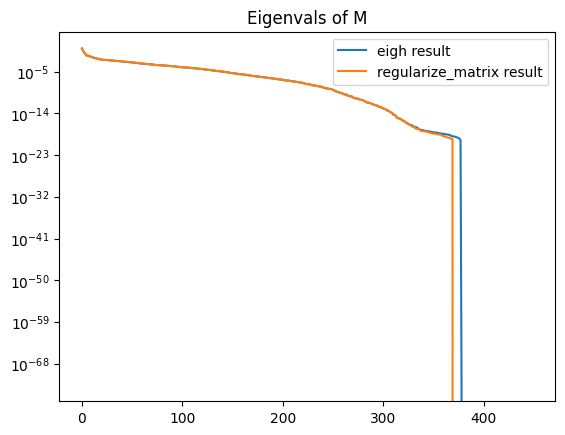

In [189]:
# Comparing the results above with the output of np.linalg.eigh

eigenvalues, eigenvectors = np.linalg.eigh(M)
eigenvalues = eigenvalues[::-1]
eigenvectors_reordered = eigenvectors[:, ::-1]

#test the eigenvectors
print('size of vectors: ', eigenvalues.size)
for i in range(eigenvalues.size):
    print(i, ' ', np.linalg.norm(M@eigenvectors_reordered.T[i]-eigenvalues[i]*eigenvectors_reordered.T[i]))

print('matrix form ', np.linalg.norm(M@eigenvectors_reordered-eigenvalues*eigenvectors_reordered,ord=np.inf))

print('Max eigenvalue: ', eigenvalues[0])
print('Consistency test between the two sets of e.vals:', np.allclose(eigenvalues,eigvals_M))

plt.plot(eigenvalues/eigenvalues[0],label='eigh result')
plt.plot(eigvals_M/eigenvalues[0],label='regularize_matrix result')
plt.legend()
plt.yscale('log')
plt.title('Eigenvals of M')
plt.show()

Max sing value of FK:  108.4053398656434


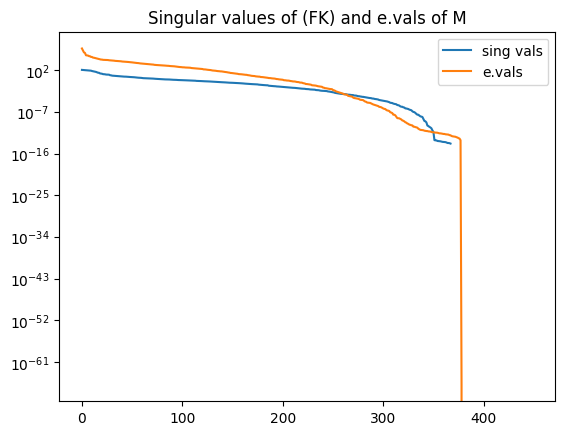

In [190]:
# SVD decomposition of FK

U,S,VT = np.linalg.svd(FK)

print('Max sing value of FK: ',S[0])

plt.plot(S[S>(1e-16 * S[0])], label='sing vals')
plt.plot(eigenvalues, label='e.vals')
plt.legend()
plt.yscale('log')
plt.title('Singular values of (FK) and e.vals of M')
plt.show()

Check that the sing values correspond to the e.vals:  True
Check that M is symmetric:  True
Check that U=V:  False
Check that U and V are orthogonal:  True   True


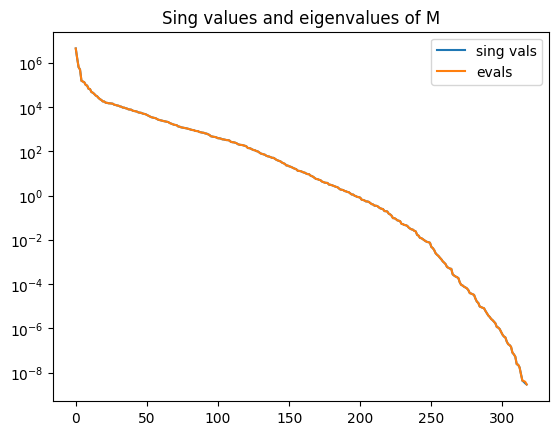

In [191]:
# SVD decomposition of M

MU,MS,MVT = np.linalg.svd(M)
#MS = MS[::-1]

print('Check that the sing values correspond to the e.vals: ', np.allclose(MS[MS > 6.0e-16 * MS[0]],eigenvalues[eigenvalues > 6.e-16 * eigenvalues[0]]))

print("Check that M is symmetric: ", is_symmetric(M))
print('Check that U=V: ', np.allclose(MU,MVT.T))
print('Check that U and V are orthogonal: ', is_orthogonal(MU), ' ', is_orthogonal(MVT))

plt.plot(MS[MS > 5.0e-16 * MS[0]],label='sing vals')
plt.plot(eigenvalues[eigenvalues > 5.e-16 * eigenvalues[0]],label='evals')
plt.legend()
plt.yscale('log')
plt.title('Sing values and eigenvalues of M')
plt.show()

In [98]:
Nvect=128 #this is the max number of eigenvectors for which U=V, the other eigenvectors do not agree. Numerical rounding issues
print('check that U = V on first evects: ', np.allclose(MU[:Nvect,:Nvect],MVT.T[:Nvect,:Nvect]))

for i in range(Nvect):
    # Check if eigenvectors and left singular vectors are the same, within a tolerance
    comparison = np.allclose(np.abs(eigenvectors_reordered[:, i]), np.abs(MU[:, i]),rtol=1.e-6)
    comparison2 = np.allclose(np.abs(R[:, i]), np.abs(MVT.T[:, i]),rtol=1.e-6)
    print(f"Eigenvector {i+1} vs Left Singular Vector {i+1}: {comparison}")
    print(f"RotR vector {i+1} vs Left Singular Vector {i+1}: {comparison2}")
for i in range(Nvect):
    # Check if eigenvectors and left singular vectors are the same, within a tolerance
    comparison = np.allclose(np.abs(eigenvectors_reordered[:, i]), np.abs(MVT[i, :]),rtol=1.e-6)
    print(f"Eigenvector {i+1} vs Right Singular Vector {i+1}: {comparison}")

print('test the matrices of eigenvectors: ', np.allclose(np.abs(R[:Nvect,:Nvect]),np.abs(eigenvectors_reordered[:Nvect,:Nvect])))
print('test the matrices of eigenvectors: ', np.allclose(np.abs(R[:Nvect,:Nvect]),np.abs(MVT.T[:Nvect,:Nvect])))
print('Check that the sing values correspond to the e.vals: ', np.allclose(MS[:Nvect],eigenvalues[:Nvect]))


check that U = V on first evects:  True
Eigenvector 1 vs Left Singular Vector 1: True
RotR vector 1 vs Left Singular Vector 1: True
Eigenvector 2 vs Left Singular Vector 2: True
RotR vector 2 vs Left Singular Vector 2: True
Eigenvector 3 vs Left Singular Vector 3: True
RotR vector 3 vs Left Singular Vector 3: True
Eigenvector 4 vs Left Singular Vector 4: True
RotR vector 4 vs Left Singular Vector 4: True
Eigenvector 5 vs Left Singular Vector 5: True
RotR vector 5 vs Left Singular Vector 5: True
Eigenvector 6 vs Left Singular Vector 6: True
RotR vector 6 vs Left Singular Vector 6: True
Eigenvector 7 vs Left Singular Vector 7: True
RotR vector 7 vs Left Singular Vector 7: True
Eigenvector 8 vs Left Singular Vector 8: True
RotR vector 8 vs Left Singular Vector 8: True
Eigenvector 9 vs Left Singular Vector 9: True
RotR vector 9 vs Left Singular Vector 9: True
Eigenvector 10 vs Left Singular Vector 10: True
RotR vector 10 vs Left Singular Vector 10: True
Eigenvector 11 vs Left Singular Vect

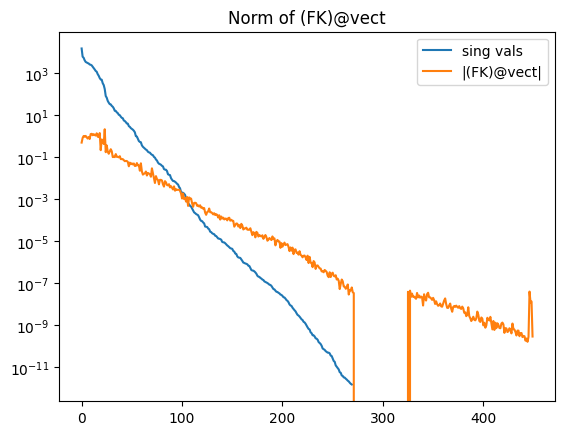

In [31]:
# Checking that the null vectors of M are also null vectors of (FK)

arr = np.zeros(len(MVT[0]))

for k in range(len(MVT[0])):
    #arr[k] = np.linalg.norm(FK@MVT[k])
    arr[k] = np.linalg.norm(FK@MVT[k])

# for k in range(200):
#     print(k, ': ', MVT[k].shape, '  ', np.linalg.norm(FK@MVT[k]))
#     #print(i, ': ', MU[i]+eigenvectors_reordered[i])

plt.plot(MS[MS > 1.0e-16 * MS[0]], label='sing vals')
plt.plot(arr, label='|(FK)@vect|')
plt.yscale("log")
plt.legend()
plt.title('Norm of (FK)@vect')
plt.show()

In [ ]:
print('Check MVT is orthogonal: ', is_identity_matrix(MVT@MVT.T))

Mrot = MVT@M@MVT.T
print('Mrot shape: ', Mrot.shape)
print('Mrot condition number: ', np.linalg.cond(Mrot)) 
print('Check Mrot is diagonal: ', is_diagonal(Mrot,1e-10))

ImageDim=120
MSub = Mrot[:ImageDim,:ImageDim]
print('MSub shape: ', MSub.shape)
print('MSub condition number: ', np.linalg.cond(MSub)) 
print('Check MSub is diagonal: ', is_diagonal(MSub,1e-10))

Check MVT is orthogonal:  True
Mrot shape:  (450, 450)
Mrot condition number:  3.5069377232728006e+35
Check Mrot is diagonal:  True
MSub shape:  (120, 120)
MSub condition number:  162022809.4311328
Check MSub is diagonal:  True


In [148]:
import itertools

In [159]:
Mpinv=np.linalg.pinv(Mrot)
dim1,dim2=Mrot.shape
for i in range(dim1):
    for j in range(dim2):
        if abs(Mpinv[i,j])>6e-6:
            print("Mpinv: ",i,j,1/Mpinv[i,j]) 


Mpinv:  0 0 14991.941843486537
Mpinv:  0 249 127377.2494729976
Mpinv:  0 334 110655.39932806454
Mpinv:  1 1 6085.404494489446
Mpinv:  2 2 5424.815491864512
Mpinv:  3 3 4129.238859135151
Mpinv:  4 4 3443.8812800329365
Mpinv:  5 5 3227.1456775483452
Mpinv:  6 6 3032.610455437477
Mpinv:  7 7 2887.4301099220797
Mpinv:  8 8 2593.9342665851364
Mpinv:  9 9 2513.4382728618893
Mpinv:  10 10 2362.1541863743173
Mpinv:  11 11 2039.1918980217526
Mpinv:  11 334 158630.80258188126
Mpinv:  12 12 1736.2594487179572
Mpinv:  13 13 1504.633018202079
Mpinv:  14 14 1277.6925548662718
Mpinv:  15 15 1173.211151941283
Mpinv:  16 16 899.9133139362921
Mpinv:  17 17 755.0545881716357
Mpinv:  17 249 -139732.86026160562
Mpinv:  17 334 -137689.3471065393
Mpinv:  18 18 586.9107934471201
Mpinv:  18 249 160598.894244429
Mpinv:  18 334 127290.93617391126
Mpinv:  19 19 499.6654063366905
Mpinv:  19 251 118986.57820827587
Mpinv:  20 20 488.03540287321937
Mpinv:  20 239 156450.37725474112
Mpinv:  20 251 -143854.9354330196
M

(450,)
(450,)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

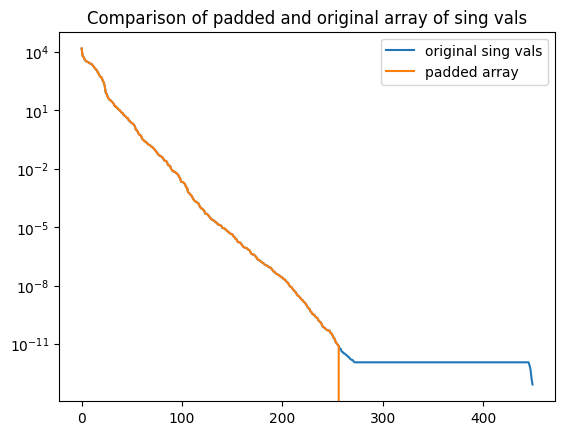

In [162]:
# Padding with zeroes,pseudoinverse and cross-check

MSpad = np.where(abs(MS) > 5.0e-16 * MS[0],MS,0)
MSpinv = np.where(abs(MS) > 5.0e-16 * MS[0],1/MS,0)
print(MSpad.shape)
print(MSpinv.shape)
print(MSpinv*MSpad)
plt.plot(MS,label='original sing vals')
plt.plot(MSpad,label='padded array')
plt.yscale('log')
plt.legend()
plt.title('Comparison of padded and original array of sing vals')
plt.show()

In [34]:
M_reconstructed = np.dot(MU, np.dot(np.diag(MSpad),MVT))
#print(MSpad)
print('difference btw original and reconstructed M: ',np.linalg.norm(M-M_reconstructed,ord=np.inf))
print('condition number of the reconstructed M: ', np.linalg.cond(M_reconstructed))

difference btw original and reconstructed M:  4.2117414106684667e-10
condition number of the reconstructed M:  inf


In [164]:
MS_orth = MS[MS > 1e-8 * MS[0]]
Dmat = np.where(abs(MS) > 1e-8 * MS[0], MS, 0)
Dmat_pinv = np.where(abs(MS) > 1e-8 * MS[0], 1/MS, 0)
size=MS.size
size_orth = MS_orth.size
print('size of the orthogonal subspace: ', MS_orth.shape)
print(size, ' ', size_orth)
#print(Dmat*Dmat_pinv)

size of the orthogonal subspace:  (117,)
450   117


In [36]:
#build a truncated matrix by summing over size_orth singular values

mat = np.zeros((MU[0].size,MVT[0].size))

print(mat.shape, ' ', M.shape)

#build the matrix by an explicit sum over sing vals
for i in range(size_orth):
    mat += MS[i] * np.outer(MU.T[i],MVT[i])

#build the matrix by cutting the SVD arrays - result should be identical
#k=size_orth
U_orth = MU[:, :size_orth]
S_orth = np.diag(MS[:size_orth])
Vt_orth = MVT[:size_orth, :]
M_approx = np.dot(U_orth, np.dot(S_orth, Vt_orth))

print(np.linalg.cond(M_approx))

print(mat.shape, M_approx.shape)
print('dist between truncations: ', np.linalg.norm(mat-M_approx))
print('dist to the original: ', np.linalg.norm(M-mat,ord=np.inf))

(450, 450)   (450, 450)
inf
(450, 450) (450, 450)
dist between truncations:  2.3003987622720724e-12
dist to the original:  0.000541243212478432


generated random vector of size:  450


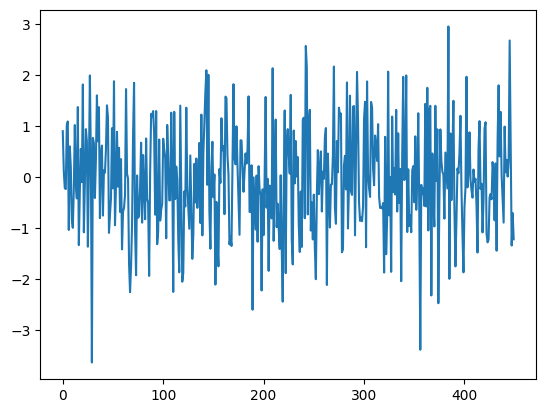

In [37]:
#generate a random vector f from a multidim gaussian
mean = np.zeros(size)
cov = np. eye(size)
ftry = np.random.multivariate_normal(mean,cov)
print('generated random vector of size: ', ftry.size)
plt.plot(ftry)

In [38]:
#projection in the orthogonal subspace to the kernel
V_orth=Vt_orth.T
fproj = V_orth@Vt_orth@ftry
print('size of fproj: ', fproj.size)
imdiff = M@fproj - M@ftry
print('norm of imdiff: ', np.linalg.norm(imdiff,ord=2))
fdiff = fproj - ftry
print('norm of fdiff: ', np.linalg.norm(fdiff))

size of fproj:  450
norm of imdiff:  0.000280264850123619
norm of fdiff:  19.130676311893417


In [41]:
for k in range(size_orth,ftry.size):
    U_tmp = MU[:, :k]
    S_tmp = np.diag(MS[:k])
    Vt_tmp = MVT[:k, :]
    M_tmp = np.dot(U_tmp, np.dot(S_tmp, Vt_tmp))
    V_tmp=Vt_tmp.T
    fproj = V_tmp@Vt_tmp@ftry
    imdiff = M@fproj - M@ftry
    print('norm of imdiff: ', k, np.linalg.norm(imdiff,ord=2),np.linalg.norm(M-M_tmp,ord=np.inf))



norm of imdiff:  117 0.000280264850123619 0.000541243212499371
norm of imdiff:  118 0.00028017450747522016 0.0004082243341148404
norm of imdiff:  119 0.0002769876699368398 0.0003959126213642487
norm of imdiff:  120 0.0002724802753485047 0.00037503237698817925
norm of imdiff:  121 0.00020934507042113103 0.00037033714345602764
norm of imdiff:  122 0.0001887091381694219 0.0003685351965978721
norm of imdiff:  123 0.00018870409974898112 0.00025145728633651235
norm of imdiff:  124 0.0001844775113758996 0.0002362361080631731
norm of imdiff:  125 8.173009271246243e-05 0.00023832574264472876
norm of imdiff:  126 8.085442956898459e-05 0.00014189776642425188
norm of imdiff:  127 7.650983845032184e-05 0.00013032648265010922
norm of imdiff:  128 7.649381576599366e-05 9.428282745529728e-05
norm of imdiff:  129 7.208920977036436e-05 9.263059610775762e-05
norm of imdiff:  130 6.656249797324622e-05 8.251771374182641e-05
norm of imdiff:  131 6.239486675517307e-05 8.440251625697071e-05
norm of imdiff:  1

In [ ]:
#rotated and truncated vectors & operators
fprime = Vt_orth@ftry
Mprime = Vt_orth@M@U_orth
print('projected sizes: ', Mprime.shape, fprime.shape)
print('condition number of Mprime: ', np.linalg.cond(Mprime))
tol_test=0.1
while is_diagonal(Mprime,tol_test):
    print('diagonal test: ', tol_test)
    tol_test=tol_test/10


projected sizes:  (117, 117) (117,)
condition number of Mprime:  87035918.31766024
diagonal test:  0.1
diagonal test:  0.01
diagonal test:  0.001
diagonal test:  0.0001
diagonal test:  1e-05
diagonal test:  1.0000000000000002e-06
diagonal test:  1.0000000000000002e-07
diagonal test:  1.0000000000000002e-08
diagonal test:  1.0000000000000003e-09
diagonal test:  True


In [43]:
ff1 = Mprime@fprime
print('shape ff1: ', ff1.shape)
ff2 = Vt_orth@M@ftry
print('shape ff2: ', ff2.shape)
ffdiff = ff1-ff2
print('size of diff: ', np.linalg.norm(ffdiff,ord=2))

shape ff1:  (117,)
shape ff2:  (117,)
size of diff:  7.244569832570162e-11


check that the NTK is symmetric:  True


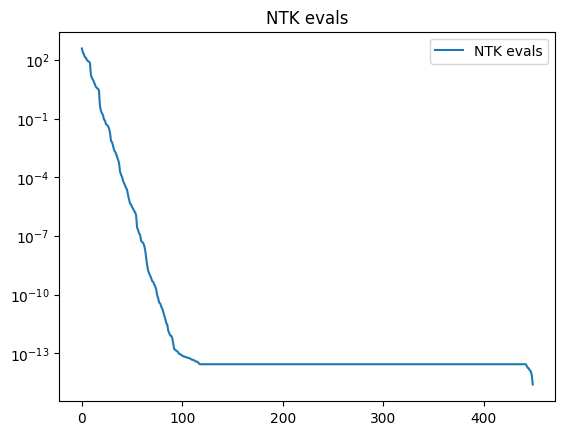

In [192]:
#SVD of the ntk
NTK_U, NTK_S, NTK_VT = np.linalg.svd(NTK_flat)
print('check that the NTK is symmetric: ', is_symmetric(NTK_flat))
plt.plot(NTK_S, label='NTK evals')
plt.legend()
plt.yscale('log')
plt.title('NTK evals')
plt.show()

check that Htilde is symmetric:  True


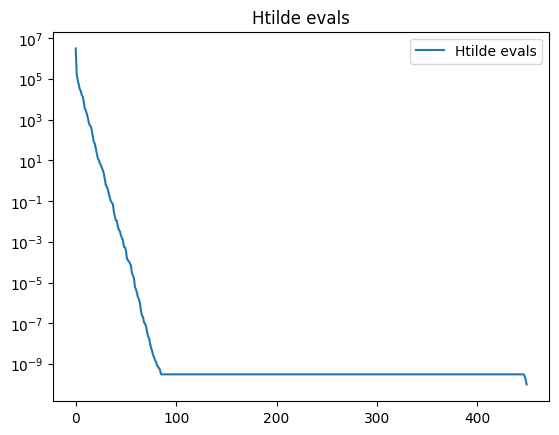

In [193]:
#construct \tilde{H} and find its SVD
Htilde = np.sqrt(D)@MVT@NTK_flat@MVT.T@np.sqrt(D)
print('check that Htilde is symmetric: ', is_symmetric(Htilde))
HtildeU,HtildeS,HtildeVT = np.linalg.svd(Htilde)
plt.plot(HtildeS, label='Htilde evals')
plt.legend()
plt.yscale('log')
plt.title('Htilde evals')
plt.show()

In [46]:
HtildeS_orth = HtildeS[HtildeS > 1e-8 * HtildeS[0]]
Hsize=HtildeS.size
Hsize_orth = HtildeS_orth.size
print('size of the orthogonal subspace: ', HtildeS_orth.shape)
print(Hsize, ' ', Hsize_orth)

size of the orthogonal subspace:  (19,)
450   19


In [47]:
HtildeU_orth = HtildeU[:, :Hsize_orth]
HtildeSmat_orth = np.diag(HtildeS[:Hsize_orth])
HtildeVt_orth = HtildeVT[:Hsize_orth, :]

Htildeprime = HtildeVt_orth@Htilde@HtildeVt_orth.T
print(Htildeprime.shape)

print(np.linalg.cond(Htildeprime))


(19, 19)
63593848.28608271


In [ ]:
#projection in the subspace orthogonal to the kernel
HtildeV_orth=HtildeVt_orth.T
TildeProj = HtildeV_orth@HtildeVt_orth
ftildeproj=TildeProj@ftry
print('size of ftildeproj: ', ftildeproj.size)
iHtildediff = Htilde@ftildeproj - Htilde@ftry
print('norm of iHtildediff: ', np.linalg.norm(iHtildediff,ord=2))
ftildediff = ftildeproj - ftry
print('norm of fdiff: ', np.linalg.norm(ftildediff))

size of ftildeproj:  450
norm of iHtildediff:  0.0008616168973432376
norm of fdiff:  21.78996708066953


(450, 1)
shape of btilde & ftrytilde:  (450,) (450, 1)
shape of btilde & ftrytilde:  (450,) (450,)


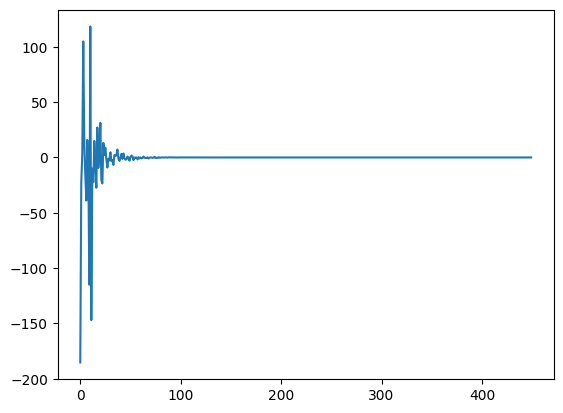

In [118]:
#construct b
ntk=NTK_flat
b = ntk @ FK.T @ Cinv.to_numpy(dtype='float64') @ Y.to_numpy('float64')
print(b.shape)
b_temp = np.sqrt(D) @ R.T @ b
b_tilde = b_temp.squeeze()
ftry_tilde = np.sqrt(D) @ R.T @ ftry
print('shape of btilde & ftrytilde: ', b_tilde.shape, b_temp.shape)
print('shape of btilde & ftrytilde: ', b_tilde.shape, ftry_tilde.shape)
#plt.plot(b_tilde)
plt.plot(ftry_tilde)

In [178]:
f_rot = MVT @ ftry
f_rot_tilde = np.sqrt(MSpad) * f_rot
f_newtilde = np.sqrt(MSpad) * MVT @ ftry
for i in range(ftry.size):
    if abs(f_newtilde[i]-f_rot_tilde[i])>1.e-6:
         print(f_newtilde[i]-f_rot_tilde[i])

185.27115745779543
22.561605601756114
-2.973547790730362
-104.81558492897705
-13.035523747916208
15.104093186153749
38.927275835401616
15.820150143450256
6.071212731305927
-114.95649093760623
-118.36820712608478
146.96465855430523
10.100149784952041
-22.290260726337895
14.95309745413099
-5.073339957795822
-27.36383995818782
27.09078043005344
-9.405505204569128
-4.941792444251146
-31.280658849954634
-20.61699779770048
23.45701955199998
13.162643007789667
2.2544983785371646
-8.788624216391245
-1.7982009026917833
-9.044918804555541
1.1339471756871085
2.6769718283787105
-4.732264379054701
3.2750952164066227
-2.3395483349106905
6.682963556851084
2.1516618647682137
1.2889732988118512
-2.123015947337581
7.184900960178828
1.1322230347134323
3.113438386263756
-0.17413481398374636
-3.2439908435074103
-1.3371771874433687
-3.6003158372655584
0.6646282539955797
1.983757672950461
-1.7274856468665036
-0.7637770669673988
0.09104144365703161
-2.9616449151700097
0.4364511762196393
1.7162682203296609
-0.

In [125]:
#testtmp=R@MVT
size_test=size_orth
MV_small=MU[:size_test,:]
MVT_small=MVT[:,:size_test]
testtmp=MV_small@MVT_small
print('size of small matrices: ', MV_small.shape, MVT_small.shape)
print('ortho test: ', {is_identity_matrix(testtmp)})
for i in range(10):
    print(i,testtmp[i,i])
for i in range(10):
    print(i,MVT[i]@M@MVT[i].T,eigvals_M[i])

    

size of small matrices:  (117, 450) (450, 117)
ortho test:  {False}
0 1.0
1 1.0
2 1.0
3 1.0
4 1.0
5 1.0
6 1.0
7 1.0
8 1.0
9 1.0
0 14991.941843486542 14991.941843486544
1 6085.404494489455 6085.404494489441
2 5424.815491864502 5424.8154918645
3 4129.238859135159 4129.23885913515
4 3443.8812800329397 3443.881280032942
5 3227.1456775483457 3227.1456775483457
6 3032.610455437474 3032.6104554374815
7 2887.430109922079 2887.4301099220797
8 2593.934266585136 2593.934266585131
9 2513.4382728618925 2513.438272861895


(117,)


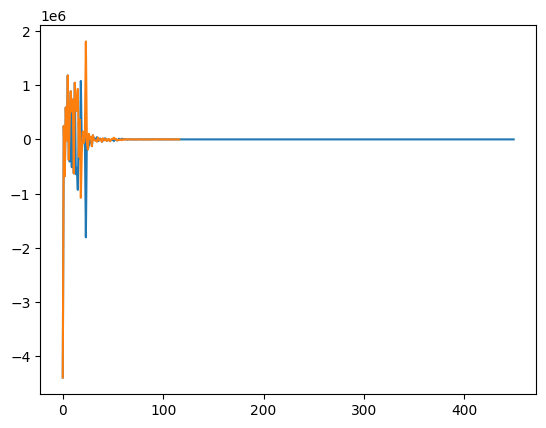

In [84]:
bb=np.sqrt(S_orth)@Vt_orth@b
bbtilde=bb.squeeze()
print(bbtilde.shape)
plt.plot(b_tilde)
plt.plot(bbtilde)

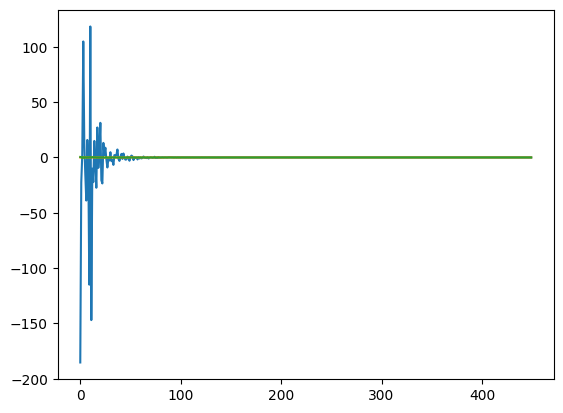

In [73]:
plt.plot(ftry_tilde)
plt.plot(HtildeVT[30])
plt.plot(HtildeVt_orth[2])

shape of explambda:  (19,)
(19,) (19,)
test:  (450,)


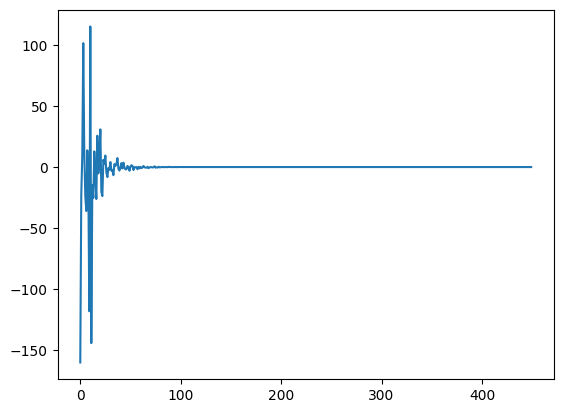

In [127]:
#function evolving ftilde
def EvolutionLO(ftilde0,btilde0,t):
    explambda=np.exp(-HtildeS_orth*t)
    print('shape of explambda: ', explambda.shape)
    coeffs_a=HtildeVt_orth@ftilde0
    ftilde0_kernel = ftilde0 - HtildeVt_orth.T@coeffs_a
    #print('test kernel component: ', np.linalg.norm(ftilde0), ' ', np.linalg.norm(Htilde@ftilde0_kernel))
    HtildeS_orth_inv = np.diag(1 / HtildeS_orth)
    coeffs_b=HtildeS_orth_inv@HtildeU_orth.T@btilde0
    print(coeffs_a.shape, coeffs_b.shape)
    return ftilde0_kernel + HtildeVt_orth.T@(explambda*coeffs_a + (1-explambda)*coeffs_b)
    #return ftilde0_kernel
    #return HtildeVt_orth.T@(explambda*coeffs_a + (1-explambda)*coeffs_b)

vec = EvolutionLO(ftry_tilde,b_tilde,0.000001)
#vec = EvolutionLO(HtildeVT[0],b_tilde,0)
#print('test: ', np.linalg.norm(vec-ftry_tilde))
print('test: ', vec.shape)
#plt.plot(ftry_tilde)
plt.plot(vec)
plt.show()


In [ ]:
#function rotating to the tilde fields
def RotateToTilde(f_in):
    f_v=MVT@f_in
    f_orth = 